# Introduction

The main idea is to analyze the passes in & out the area.

The first step is to find wich passes are in & out, because in the data there are only coordintes of where the players where located

So, the court will be divided in 1x1 meters squares.

With this, we will be able to work with origin and destiny squares instead of specific coordinates.

After assignig a square to each origin and destiny pass, a Machine Learning model will be fitted, to predict the seconds between the pass inside the box and a goal.

The features will be the square, the possition of the player and the game time.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from kloppy.domain import PitchDimensions
import kloppy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import json
import dask.dataframe as dd
import itertools
import math
from itertools import product
import random

C:\Users\const\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Read Data

Read data from Oakland UCL 2023

In [2]:
data = pd.read_parquet('USLChampionship_2023.parquet')

In [3]:
def coord_x(arr):
    if arr is not None and len(arr) > 0:
        return arr[0]
    else:
        return None

In [4]:
def coord_y(arr):
    if arr is not None and len(arr) > 0:
        return arr[1]
    else:
        return None

In [5]:
#def preprocess(df):
#    df = df[~df.location.isnull()]
#    df = df[~df.pass_end_location.isnull()]
#    df[['location_x' , 'location_y']] = pd.DataFrame(df['location'].apply(lambda x: json.loads(x.replace("'", "\""))).tolist())
#    df[['location_x_destiny' , 'location_y_destiny']] = pd.DataFrame(df['pass_end_location'].apply(lambda x: json.loads(x.replace("'", "\""))).tolist())
#    df['big_area_origin'] = np.where(df.location_x is None, 0,
#                            np.where(((df.location_x<=20) & (df.location_x>=0) & (df.location_y >= 20) & (df.location_y<=60)) |
#                                     ((df.location_x<=120) & (df.location_x>=100) & (df.location_y >= 20) & (df.location_y<=60)),1,0))
#    df['big_area_destiny'] = np.where(df.location_x_destiny is None, 0,
#                            np.where(((df.location_x_destiny<=20) & (df.location_x_destiny>=0) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)) |
#                                     ((df.location_x_destiny<=120) & (df.location_x_destiny>=100) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)),1,0))
#    matches = df[['match_id', 'team']].drop_duplicates()
#    passes = df[df['type'] == 'Pass'].dropna(axis = 1, how = 'all')
#    passes = passes[(passes['pass_type'].isin(['Recovery', 'Interception'])) | (passes['pass_type'].isnull())].reset_index(drop = True)
#    passes = passes.merge(matches, on='match_id', suffixes=('', '_opp'), how='left')
#    passes = passes[passes['team'] != passes['team_opp']].reset_index(drop = True)
#    passes.rename(columns={'team_opp': 'opp_team'}, inplace=True)
#    passes['pass_outcome'] = passes['pass_outcome'].fillna('Complete')
#    #passes = passes[(passes['location_x'] >= 60) & (passes['location_y'] >= 18) & (passes['location_y'] <= 62 ) & (passes['location_y_destiny'] >= 18) & (passes['location_y_destiny'] <= 62 ) & (passes['location_x_destiny'] >= 102)]
#    return passes

In [6]:
def preprocess(df):
    df['location_x'] = df.location.apply(coord_x)
    df['location_y'] = df.location.apply(coord_y)
    df['location_x_destiny'] = df.pass_end_location.apply(coord_x)
    df['location_y_destiny'] = df.pass_end_location.apply(coord_y)
    df['big_area_origin'] = np.where(df.location_x is None, 0,
                            np.where(((df.location_x<=20) & (df.location_x>=0) & (df.location_y >= 20) & (df.location_y<=60)) |
                                     ((df.location_x<=120) & (df.location_x>=100) & (df.location_y >= 20) & (df.location_y<=60)),1,0))
    df['big_area_destiny'] = np.where(df.location_x_destiny is None, 0,
                            np.where(((df.location_x_destiny<=20) & (df.location_x_destiny>=0) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)) |
                                     ((df.location_x_destiny<=120) & (df.location_x_destiny>=100) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)),1,0))
    return df

In [7]:
data = preprocess(data)

In [8]:
def preprocess2(df):
    matches = df[['match_id', 'team']].drop_duplicates()
    passes = df[(df['type'] == 'Pass') | ((df['type'] == 'Shot') & (df['shot_outcome'] == 'Goal'))]
    passes = passes[(passes['pass_type'].isin(['Recovery', 'Interception'])) | (passes['pass_type'].isnull())].reset_index(drop = True)
    passes = passes.merge(matches, on='match_id', suffixes=('', '_opp'), how='left')
    passes = passes[passes['team'] != passes['team_opp']].reset_index(drop = True)
    passes.rename(columns={'team_opp': 'opp_team'}, inplace=True)
    passes['pass_outcome'] = passes['pass_outcome'].fillna('Complete')
    passes = passes[passes['pass_outcome']=='Complete']
    return passes

In [9]:
data = preprocess2(data)

In [10]:
data = data.reset_index(drop=True)

# Court viz

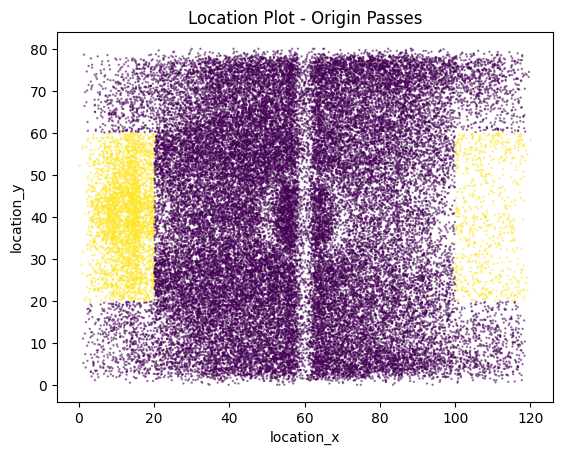

In [11]:
plt.scatter(data['location_x'].head(50000), data['location_y'].head(50000), alpha = 0.5, c = data['big_area_origin'].head(50000), s = 0.5)

# Add labels and title
plt.xlabel('location_x')
plt.ylabel('location_y')
plt.title('Location Plot - Origin Passes')

# Show the plot
plt.show()

# Court Function

In [12]:
def plot_soccer_court():
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the figure size and axis limits
    fig.set_size_inches(7, 5)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)

    # Plot the outer boundary of the soccer court
    ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color='black')
    
    # Center line
    ax.plot([60, 60], [0, 80], color='black')
    
    # Middle circle
    ax.add_patch(plt.Circle((60, 40), 9, color='black', fill=False))
    
    # Penalty areas
    ax.plot([0, 20], [20, 20], color='black')
    ax.plot([0, 20], [60, 60], color='black')
    ax.plot([20, 20], [20, 60], color='black')
    
    ax.plot([100, 120], [20, 20], color='black')
    ax.plot([100, 120], [60, 60], color='black')
    ax.plot([100, 100], [20, 60], color='black')
     
    
    # Set the aspect ratio to equal
    ax.set_aspect('equal')

    # Remove the axis labels and ticks
    ax.axis('off')

# Square dictionary

To know in wich square of 1x1 meters a pass belongs, first we need to have a dictionary of each square, with the 4 arists of each square.

Then, we can look in which square each pass is inside

Get a list of all the right superior arist of each square

 - sr: superior right arist
 - ir: inferior right arist
 - sl: superior left arist
 - il: inferior left arist

In [13]:
# Define the sets of numbers
l = range(1, 121)
h = range(1, 81)

# Generate the combinations for superior right arists
arists = list(itertools.product(l, h))
arists = pd.DataFrame(arists, columns=['x_sr', 'y_sr'])

Add the other 3 arists of each square

In [14]:
# Inferior right
arists['x_ir'] = arists['x_sr']
arists['y_ir'] = arists['y_sr'] - 1

# superior left
arists['x_sl'] = arists['x_sr'] - 1
arists['y_sl'] = arists['y_sr']

# inferior left
arists['x_il'] = arists['x_sr'] - 1
arists['y_il'] = arists['y_sr'] - 1

Add a square name

In [15]:
arists['square'] = 'S'+arists['x_sr'].astype(str)+arists['y_sr'].astype(str)

In [16]:
arists.tail()

x_sr  y_sr  x_ir  y_ir  x_sl  y_sl  x_il  y_il  square
9595   120    76   120    75   119    76   119    75  S12076
9596   120    77   120    76   119    77   119    76  S12077
9597   120    78   120    77   119    78   119    77  S12078
9598   120    79   120    78   119    79   119    78  S12079
9599   120    80   120    79   119    80   119    79  S12080

Calculate the centroid of each square

In [17]:
arists['centroid_x'] = arists['x_sr']-0.5
arists['centroid_y'] = arists['y_sr']-0.5

In [18]:
arists.head()

x_sr  y_sr  x_ir  y_ir  x_sl  y_sl  x_il  y_il square  centroid_x  \
0     1     1     1     0     0     1     0     0    S11         0.5   
1     1     2     1     1     0     2     0     1    S12         0.5   
2     1     3     1     2     0     3     0     2    S13         0.5   
3     1     4     1     3     0     4     0     3    S14         0.5   
4     1     5     1     4     0     5     0     4    S15         0.5   

   centroid_y  
0         0.5  
1         1.5  
2         2.5  
3         3.5  
4         4.5

Now, we need to create a function that assigns a square to each pass given

In [19]:
# def court_square(x,y):
#     arists_aux = arists.copy()
#     arists_aux['x'] = x
#     arists_aux['y'] = y
#     arists_aux['distance_sr'] = (((arists_aux['x_sr']-arists_aux['x'])**2)+(arists_aux['y_sr']-arists_aux['y'])**2)**(0.5)
#     arists_aux['distance_ir'] = (((arists_aux['x_ir']-arists_aux['x'])**2)+(arists_aux['y_ir']-arists_aux['y'])**2)**(0.5)
#     arists_aux['distance_sl'] = (((arists_aux['x_sl']-arists_aux['x'])**2)+(arists_aux['y_sl']-arists_aux['y'])**2)**(0.5)
#     arists_aux['distance_il'] = (((arists_aux['x_il']-arists_aux['x'])**2)+(arists_aux['y_il']-arists_aux['y'])**2)**(0.5)
#     arists_aux = arists_aux[arists_aux.distance_sr <= 1]
#     arists_aux = arists_aux[arists_aux.distance_ir <= 1]
#     arists_aux = arists_aux[arists_aux.distance_sl <= 1]
#     arists_aux = arists_aux[arists_aux.distance_il <= 1]
#     square = arists_aux.head(1)
#     square = square.square
#     return square

In [20]:
# data['square_origin'] = court_square(data['location_x'], data['location_y'])
# data['square_destiny'] = court_square(data['location_x_destiny'], data['location_y_destiny'])

In [21]:
# def court_square_centroidx(x,y):
#     arists_aux = arists
#     arists_aux['x'] = x
#     arists_aux['y'] = y
#     arists_aux['distance_sr'] = (((arists['x_sr']-arists['x'])**2)+(arists['y_sr']-arists['y'])**2)**(0.5)
#     arists_aux['distance_ir'] = (((arists['x_ir']-arists['x'])**2)+(arists['y_ir']-arists['y'])**2)**(0.5)
#     arists_aux['distance_sl'] = (((arists['x_sl']-arists['x'])**2)+(arists['y_sl']-arists['y'])**2)**(0.5)
#     arists_aux['distance_il'] = (((arists['x_il']-arists['x'])**2)+(arists['y_il']-arists['y'])**2)**(0.5)
#     arists_aux = arists_aux[arists_aux.distance_sr <= 1]
#     arists_aux = arists_aux[arists_aux.distance_ir <= 1]
#     arists_aux = arists_aux[arists_aux.distance_sl <= 1]
#     arists_aux = arists_aux[arists_aux.distance_il <= 1]
#     square = arists_aux.head(1)
#     cent_x = square.centroid_x
#     cent_y = square.centroid_y
#     return cent_x

In [22]:
# data['square_origin_centroid_x'] = court_square_centroidx(data['location_x'], data['location_y'])
# data['square_destiny_centroid_x'] = court_square_centroidx(data['location_x_destiny'], data['location_y_destiny'])

In [23]:
# def court_square_centroidy(x,y):
#     arists_aux = arists
#     arists_aux['x'] = x
#     arists_aux['y'] = y
#     arists_aux['distance_sr'] = (((arists['x_sr']-arists['x'])**2)+(arists['y_sr']-arists['y'])**2)**(0.5)
#     arists_aux['distance_ir'] = (((arists['x_ir']-arists['x'])**2)+(arists['y_ir']-arists['y'])**2)**(0.5)
#     arists_aux['distance_sl'] = (((arists['x_sl']-arists['x'])**2)+(arists['y_sl']-arists['y'])**2)**(0.5)
#     arists_aux['distance_il'] = (((arists['x_il']-arists['x'])**2)+(arists['y_il']-arists['y'])**2)**(0.5)
#     arists_aux = arists_aux[arists_aux.distance_sr <= 1]
#     arists_aux = arists_aux[arists_aux.distance_ir <= 1]
#     arists_aux = arists_aux[arists_aux.distance_sl <= 1]
#     arists_aux = arists_aux[arists_aux.distance_il <= 1]
#     square = arists_aux.head(1)
#     cent_x = square.centroid_x
#     cent_y = square.centroid_y
#     return cent_y

In [24]:
# data['square_origin_centroid_y'] = court_square_centroidx(data['location_x'], data['location_y'])
# data['square_destiny_centroid_y'] = court_square_centroidx(data['location_x_destiny'], data['location_y_destiny'])

# Drop passes errors

Drop errors with no data recoleted.

These passes are those where all _second_ is in 0, por a certain team & possession

In [25]:
# Group by 'team' and 'possession', and calculate the number of distinct timestamps for each group
data = data[data.team == 'Oakland Roots SC']

dts = data.groupby(['team', 'possession','match_id']).apply(lambda x: x.assign(distinct_ts=len(x['timestamp'].unique())))

data['distinct_ts'] = dts['distinct_ts'].tolist()

data = data[data['distinct_ts'] != 1]

data = data.drop('distinct_ts', axis=1)

# Pass flag

Add a flag for passes that are from outside the box to inside the box

In [26]:
data['flag1'] = np.where(((data.location_x_destiny<=120) & (data.location_x_destiny>=100) & (data.location_y_destiny >= 20) & (data.location_y_destiny<=60)),1,0)
data['flag2'] = np.where(~((data.location_x<=120) & (data.location_x>=100) & (data.location_y >= 20) & (data.location_y<=60)),1,0)
data['flag_pass_outIn'] = np.where((data.flag1 == 1) & (data.flag2 == 1),1,0)
data = data.drop(columns = 'flag1')
data = data.drop(columns = 'flag2')

Add a possesion in put flag, to identify possessions with at least one pass from outside to inside the box, begining the possesion with the pass from out to inside the box

In [27]:
# Grouping and arranging the dataframe
data = data.groupby(['possession', 'match_id', 'team']).apply(lambda x: x.sort_values('timestamp')).reset_index(drop=True)

# Grouping and cumulatively summing the 'flag_pass_outIn' column
data['flag_pass_outIn_possession'] = data.groupby(['possession', 'match_id', 'team'])['flag_pass_outIn'].cumsum()

In [28]:
len(data)

10369

## Goal Flag

Add a flag to identify those possessions that finished in goal

In [29]:
aux = data.copy()
aux['flag_goal'] = np.where(aux['shot_outcome']=='Goal', 1, 0)
aux['flag_goal'] = aux.groupby(['possession', 'match_id', 'team'])['flag_goal'].transform('sum')
data['flag_goal'] = aux['flag_goal']
del(aux)

# Example

Example of a possession with:
 - A pass from out to inside the are
 - Finished in goal

In [30]:
data[(data.possession==155) & (data.match_id == 3878912)][['team','match_id','possession','timestamp','second','location_x','location_y','location_x_destiny','location_y_destiny','pass_outcome','shot_outcome','type','flag_pass_outIn_possession','flag_pass_outIn','flag_goal']]

team  match_id  possession     timestamp  second  \
9312  Oakland Roots SC   3878912         155  00:38:57.425      57   
9313  Oakland Roots SC   3878912         155  00:39:03.561       3   
9314  Oakland Roots SC   3878912         155  00:39:05.900       5   
9315  Oakland Roots SC   3878912         155  00:39:08.001       8   
9316  Oakland Roots SC   3878912         155  00:39:11.315      11   
9317  Oakland Roots SC   3878912         155  00:39:15.547      15   
9318  Oakland Roots SC   3878912         155  00:39:17.354      17   
9319  Oakland Roots SC   3878912         155  00:39:20.774      20   
9320  Oakland Roots SC   3878912         155  00:39:26.406      26   
9321  Oakland Roots SC   3878912         155  00:39:28.449      28   
9322  Oakland Roots SC   3878912         155  00:39:30.479      30   
9323  Oakland Roots SC   3878912         155  00:39:32.543      32   
9324  Oakland Roots SC   3878912         155  00:39:34.782      34   
9325  Oakland Roots SC   3878912         155  00:39:37.331      37   
9326  Oakland Roots SC   3878912         155  00:39:38.785      38   
9327  Oakland Roots SC   3878912         155  00:39:41.163      41   
9328  Oakland Roots SC   3878912         155  00:39:42.503      42   

      location_x  location_y  location_x_destiny  location_y_destiny  \
9312        37.9        18.9                55.0                 5.8   
9313        80.6        12.6                62.2                27.3   
9314        62.8        26.8                60.2                41.7   
9315        61.9        44.0                55.7                73.1   
9316        58.2        73.5                70.1                77.4   
9317        63.5        77.8                68.9                63.6   
9318        69.5        62.8                63.3                47.1   
9319        65.4        44.9                85.1                 7.1   
9320        90.5        23.4                78.2                 6.0   
9321        79.2         6.0                93.1                 3.2   
9322        93.1         3.2                82.0                 4.9   
9323        82.0         4.9                85.8                24.3   
9324        85.8        22.1                83.9                 5.6   
9325        84.9         5.6               100.6                 6.6   
9326        99.9         9.0               102.8                20.1   
9327       115.1        22.0               113.8                41.9   
9328       113.8        41.9                 NaN                 NaN   

     pass_outcome shot_outcome  type  flag_pass_outIn_possession  \
9312     Complete         None  Pass                           0   
9313     Complete         None  Pass                           0   
9314     Complete         None  Pass                           0   
9315     Complete         None  Pass                           0   
9316     Complete         None  Pass                           0   
9317     Complete         None  Pass                           0   
9318     Complete         None  Pass                           0   
9319     Complete         None  Pass                           0   
9320     Complete         None  Pass                           0   
9321     Complete         None  Pass                           0   
9322     Complete         None  Pass                           0   
9323     Complete         None  Pass                           0   
9324     Complete         None  Pass                           0   
9325     Complete         None  Pass                           0   
9326     Complete         None  Pass                           1   
9327     Complete         None  Pass                           1   
9328     Complete         Goal  Shot                           1   

      flag_pass_outIn  flag_goal  
9312                0          1  
9313                0          1  
9314                0          1  
9315                0          1  
9316                0          1  
9317                0    

Because now we identified the goal in a possession, we can drop the row with the shot

In [31]:
data = data[data.type == 'Pass']

# Keep only Out-In passes

Keep only possessions with a pass from outside to inside the box, and only since that pass

In [32]:
data = data[data.flag_pass_outIn_possession == 1]

# Quick Descriptives

## Number of possessions

In [33]:
len(data[['possession','match_id']].drop_duplicates())

228

## Number of possessions with and without goal

In [34]:
data[['possession','match_id','flag_goal']].drop_duplicates().groupby('flag_goal').size()

flag_goal
0    208
1     20
dtype: int64

# Pass Height

Combine Low and ground passes in a single cluster

In [39]:
data['pass_height'] = np.where(data['pass_height'] != 'High Pass', 'Low or Ground Pass', 'High Pass')

# Data creation

Create data for the model.

The data will contain:
 - Origin and Destiny Square for the first pass from outside to inside the area
 - If the possession finished in Goal
 - Pass type
 - Position

In [47]:
data_model = data[data.flag_pass_outIn == 1][['match_id','team','possession','location_x','location_y',
                                              'location_x_destiny','location_y_destiny','flag_goal',
                                              'position','pass_type','duration','pass_length','pass_angle','pass_height']]

# Fit Model

A LightGBM will be fitted

In [48]:
import lightgbm as lgb
import optuna
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, log_loss, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## Set features

In [49]:
features = ['location_x','location_y',
            #'pass_angle','position','duration',
            'location_x_destiny','location_y_destiny','pass_height','pass_length']

In [50]:
colcat = ['pass_height']

In [51]:
for i in colcat:
    data_model[i] = data_model[i] .astype('category')

## Split

In [52]:
seed=93
train_df, valid_df = train_test_split(data_model, test_size = 0.2, random_state = seed)

In [53]:
y_train = train_df.flag_goal
y_valid = valid_df.flag_goal

In [54]:
train_df_features = train_df[features]
valid_df_features = valid_df[features]
data_model_feat   = data_model[features]

In [55]:
cat_indices = [i for i, col in enumerate(train_df_features.columns) if col in colcat]

Create LGM data frame

In [56]:
dtrain = lgb.Dataset(train_df_features, label = train_df.flag_goal, categorical_feature = cat_indices, free_raw_data=False)
dvalid = lgb.Dataset(valid_df_features, label = valid_df.flag_goal, categorical_feature = cat_indices, free_raw_data=False)
dcomp  = lgb.Dataset(data_model_feat,   label = data_model.flag_goal, categorical_feature = cat_indices, free_raw_data=False)

## Optimize metaparameters

In [57]:
def objective(trial):
    random_seed = 69
    np.random.seed(random_seed)
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': 'false',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log = True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log = True),
        'num_leaves': trial.suggest_int('num_leaves', 2^1, 2^10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.95),
        
    }
    
    np.random.seed(random_seed)
    gbm = lgb.train(param, dtrain,valid_sets = [dcomp])
    preds = gbm.predict(data_model_feat)
    pred_labels = np.rint(preds)
    accuracy = balanced_accuracy_score(data_model.flag_goal, pred_labels)
    return(accuracy)

In [58]:
study = optuna.create_study(direction = 'maximize')

[I 2023-11-12 15:22:59,938] A new study created in memory with name: no-name-9e75f138-7097-4032-8f18-d1637ed6502d


In [59]:
study.optimize(objective, n_trials = 100)

[I 2023-11-12 15:23:01,351] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.48834554468579017, 'lambda_l2': 0.024784134088909476, 'num_leaves': 7, 'feature_fraction': 0.5018487269295971, 'bagging_fraction': 0.9729599509495542, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 2, 'learning_rate': 0.5295596250747026}. Best is trial 0 with value: 0.5.
[I 2023-11-12 15:23:01,364] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 4.9707527002132685e-05, 'lambda_l2': 7.817114028942687e-08, 'num_leaves': 4, 'feature_fraction': 0.5436764000513197, 'bagging_fraction': 0.6197505839145738, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 17, 'learning_rate': 0.8515212059845625}. Best is trial 0 with value: 0.5.
[I 2023-11-12 15:23:01,376] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.0012782137099548864, 'lambda_l2': 0.009113281516731997, 'num_leaves': 4, 'feature_fraction': 0.4090922679600696, 'bagging_fraction': 0.9014465509825523,

[I 2023-11-12 15:23:02,202] Trial 21 finished with value: 0.8975961538461539 and parameters: {'lambda_l1': 0.016111029293927704, 'lambda_l2': 1.3792267017485926, 'num_leaves': 7, 'feature_fraction': 0.20288753151612388, 'bagging_fraction': 0.8786056775176082, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 13, 'learning_rate': 0.5602429252364378}. Best is trial 19 with value: 0.8975961538461539.
[I 2023-11-12 15:23:02,273] Trial 22 finished with value: 0.8701923076923077 and parameters: {'lambda_l1': 0.026295267009919982, 'lambda_l2': 2.1733941316359093, 'num_leaves': 7, 'feature_fraction': 0.22601188979627204, 'bagging_fraction': 0.878233208656373, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 13, 'learning_rate': 0.5683381229991379}. Best is trial 19 with value: 0.8975961538461539.
[I 2023-11-12 15:23:02,339] Trial 23 finished with value: 0.8225961538461539 and parameters: {'lambda_l1': 0.011854064339135743, 'lambda_l2': 7.3070758540154515, 'num_leaves': 7, 'featu

[I 2023-11-12 15:23:03,537] Trial 42 finished with value: 0.8725961538461539 and parameters: {'lambda_l1': 0.003523409905170478, 'lambda_l2': 9.449029935473792, 'num_leaves': 8, 'feature_fraction': 0.28007115423384693, 'bagging_fraction': 0.8873551317967032, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 10, 'learning_rate': 0.618806072365789}. Best is trial 39 with value: 0.9.
[I 2023-11-12 15:23:03,601] Trial 43 finished with value: 0.8951923076923077 and parameters: {'lambda_l1': 0.0006584548882683764, 'lambda_l2': 1.0205238286843357, 'num_leaves': 7, 'feature_fraction': 0.209503309607534, 'bagging_fraction': 0.8308374716927598, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.6781883281956317}. Best is trial 39 with value: 0.9.
[I 2023-11-12 15:23:03,667] Trial 44 finished with value: 0.8975961538461539 and parameters: {'lambda_l1': 0.00807234278446648, 'lambda_l2': 0.533593380736596, 'num_leaves': 8, 'feature_fraction': 0.45054381841036867,

[I 2023-11-12 15:23:05,057] Trial 64 finished with value: 0.8927884615384616 and parameters: {'lambda_l1': 0.0037670804270660795, 'lambda_l2': 0.6385430401340464, 'num_leaves': 6, 'feature_fraction': 0.14543839688795632, 'bagging_fraction': 0.9682327185264072, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 12, 'learning_rate': 0.5984338589081837}. Best is trial 39 with value: 0.9.
[I 2023-11-12 15:23:05,140] Trial 65 finished with value: 0.8725961538461539 and parameters: {'lambda_l1': 0.016032808311099423, 'lambda_l2': 5.977829357409109, 'num_leaves': 7, 'feature_fraction': 0.2529363794019702, 'bagging_fraction': 0.9340935139017854, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 7, 'learning_rate': 0.6808003652835285}. Best is trial 39 with value: 0.9.
[I 2023-11-12 15:23:05,222] Trial 66 finished with value: 0.7951923076923078 and parameters: {'lambda_l1': 0.0012056587090544483, 'lambda_l2': 1.6478052972060806, 'num_leaves': 7, 'feature_fraction': 0.11359575014517

[I 2023-11-12 15:23:06,671] Trial 86 finished with value: 0.9 and parameters: {'lambda_l1': 0.21233662578773177, 'lambda_l2': 0.0053305249183996945, 'num_leaves': 7, 'feature_fraction': 0.3688935934096907, 'bagging_fraction': 0.9504012178282338, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 6, 'learning_rate': 0.6579341834257745}. Best is trial 39 with value: 0.9.
[I 2023-11-12 15:23:06,738] Trial 87 finished with value: 0.9 and parameters: {'lambda_l1': 0.2484164510668434, 'lambda_l2': 0.004718542496757729, 'num_leaves': 7, 'feature_fraction': 0.3696480036823812, 'bagging_fraction': 0.9670078024289653, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 6, 'learning_rate': 0.6731151713390283}. Best is trial 39 with value: 0.9.
[I 2023-11-12 15:23:06,809] Trial 88 finished with value: 0.8975961538461539 and parameters: {'lambda_l1': 0.23089245955873688, 'lambda_l2': 0.003924972507457352, 'num_leaves': 7, 'feature_fraction': 0.39695669376706544, 'bagging_fraction': 0.95249

In [60]:
trial = study.best_trial

In [61]:
print("Value: {}".format(trial.value))

Value: 0.9225961538461538


In [62]:
print('Params:')
for key, value in trial.params.items():
    print("   {}: {}".format(key,value))

Params:
   lambda_l1: 0.5158921536950432
   lambda_l2: 0.014437069896502388
   num_leaves: 7
   feature_fraction: 0.42321798889811385
   bagging_fraction: 0.9201926936111687
   bagging_freq: 1
   min_child_samples: 5
   max_depth: 6
   learning_rate: 0.7327910763870497


## Model with best metaparameters

Fit the model with the best metaparameters

In [63]:
best_params = trial.params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['verbosity'] = -1
best_params['boosting_type'] = 'gbdt'
best_params['feature_pre_filter'] = 'false'
best_params['random_state'] = 69

In [64]:
np.random.seed(69)
gbm_best = lgb.train(best_params, dtrain, valid_sets = [dtrain,dvalid])

Save model in local

In [65]:
#gbm_best.save_model('C:/Users/const/OneDrive/Documentos/Aztec/2023/Oakland_Roots/Passes_InOut_Area/Models/ModelLGM_OutIn_202322.mdl')

## Performance Metrics

In [66]:
pred_train = gbm_best.predict(data_model_feat)
labels_train = np.rint(pred_train)

In [67]:
accuracy_train = balanced_accuracy_score(data_model.flag_goal, labels_train)
auc_train      = roc_auc_score(data_model.flag_goal, labels_train)
logloss_train  = log_loss(data_model.flag_goal, labels_train)
f1_score_train = f1_score(data_model.flag_goal, labels_train)

In [68]:
print('Accuracy Train: {:1.2%}'.format(accuracy_train))

print('AUC Train: {:1.2%}'.format(auc_train))

print('Log-Loss: ',round(logloss_train,5))

print('F1: ',round(f1_score_train,3))

Accuracy Train: 89.04%
AUC Train: 89.04%
Log-Loss:  1.2119
F1:  0.8


## Feature Importance

In [69]:
feature_imp_df = pd.DataFrame([data_model_feat.columns, gbm_best.feature_importance()]).T.sort_values([1], ascending =[False])
feature_imp_df.columns = ['feature', 'importance']
feature_imp_df = feature_imp_df.sort_values(['importance'])

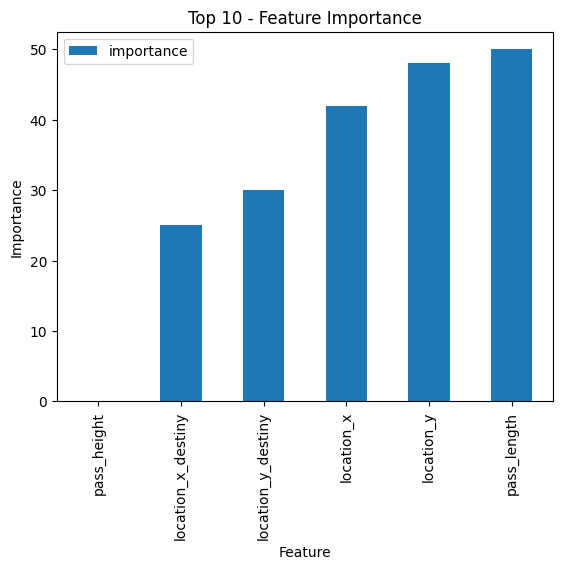

In [70]:
# Plot the data using matplotlib
feature_imp_df.plot(kind='bar', x = 'feature', y='importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 - Feature Importance')
plt.show()

In [71]:
feature_imp_df = feature_imp_df.sort_values(['importance'], ascending =[False])

## Marginal effects

### Top 1 - Feature Effect

In [73]:
pp_df = data_model_feat.copy()
for column in data_model_feat.columns:
    if data_model_feat[column].dtype == 'float64':
        avg = data_model_feat[column].mean()
        pp_df[column] = avg
    else:
        col1 = data_model_feat[column].astype(str)
        mode = col1.mode().values[0]
        pp_df[column] = mode

for i in colcat:
    pp_df[i] = pp_df[i].astype('category')

feature_to_analyze = feature_imp_df.reset_index().feature[0]
pp_df[feature_to_analyze] = data_model_feat[feature_to_analyze].tolist()

prediction = gbm_best.predict(pp_df)
pp_df['pred'] = prediction
pp_df = pp_df.sort_values([feature_to_analyze])
#pp_df = pp_df[pp_df[feature_to_analyze]<50]

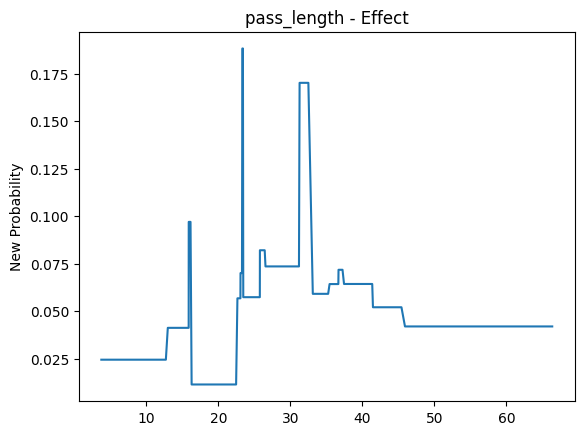

In [74]:
plt.plot(pp_df[feature_to_analyze], pp_df['pred'])
plt.xlabel('')
plt.ylabel('New Probability')
plt.title(feature_to_analyze +' - Effect')
plt.show()

### Top 2 - Feature Effect

In [75]:
pp_df = data_model_feat.copy()
for column in data_model_feat.columns:
    if data_model_feat[column].dtype == 'float64':
        avg = data_model_feat[column].mean()
        pp_df[column] = avg
    else:
        col1 = data_model_feat[column].astype(str)
        mode = col1.mode().values[0]
        pp_df[column] = mode

for i in colcat:
    pp_df[i] = pp_df[i].astype('category')

feature_to_analyze = feature_imp_df.reset_index().feature[1]
pp_df[feature_to_analyze] = data_model_feat[feature_to_analyze].tolist()

prediction = gbm_best.predict(pp_df)
pp_df['pred'] = prediction
pp_df = pp_df.sort_values([feature_to_analyze])
#pp_df = pp_df[pp_df[feature_to_analyze]<50]

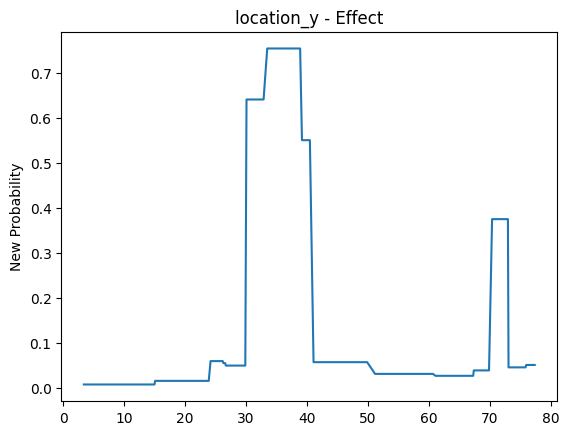

In [76]:
plt.plot(pp_df[feature_to_analyze], pp_df['pred'])
plt.xlabel('')
plt.ylabel('New Probability')
plt.title(feature_to_analyze +' - Effect')
plt.show()

### Top 3 - Feature Effect

In [77]:
pp_df = data_model_feat.copy()
for column in data_model_feat.columns:
    if data_model_feat[column].dtype == 'float64':
        avg = data_model_feat[column].mean()
        pp_df[column] = avg
    else:
        col1 = data_model_feat[column].astype(str)
        mode = col1.mode().values[0]
        pp_df[column] = mode

for i in colcat:
    pp_df[i] = pp_df[i].astype('category')

feature_to_analyze = feature_imp_df.reset_index().feature[2]
pp_df[feature_to_analyze] = data_model_feat[feature_to_analyze].tolist()

prediction = gbm_best.predict(pp_df)
pp_df['pred'] = prediction
pp_df = pp_df.sort_values([feature_to_analyze])
#pp_df = pp_df[pp_df[feature_to_analyze]<50]

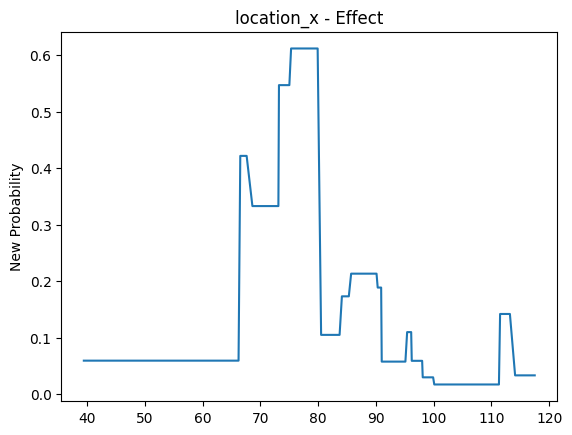

In [78]:
plt.plot(pp_df[feature_to_analyze], pp_df['pred'])
plt.xlabel('')
plt.ylabel('New Probability')
plt.title(feature_to_analyze +' - Effect')
plt.show()

### Top 4 - Feature Effect

In [79]:
pp_df = data_model_feat.copy()
for column in data_model_feat.columns:
    if data_model_feat[column].dtype == 'float64':
        avg = data_model_feat[column].mean()
        pp_df[column] = avg
    else:
        col1 = data_model_feat[column].astype(str)
        mode = col1.mode().values[0]
        pp_df[column] = mode

for i in colcat:
    pp_df[i] = pp_df[i].astype('category')

feature_to_analyze = feature_imp_df.reset_index().feature[3]
pp_df[feature_to_analyze] = data_model_feat[feature_to_analyze].tolist()

prediction = gbm_best.predict(pp_df)
pp_df['pred'] = prediction
pp_df = pp_df.sort_values([feature_to_analyze])
#pp_df = pp_df[pp_df[feature_to_analyze]<50]

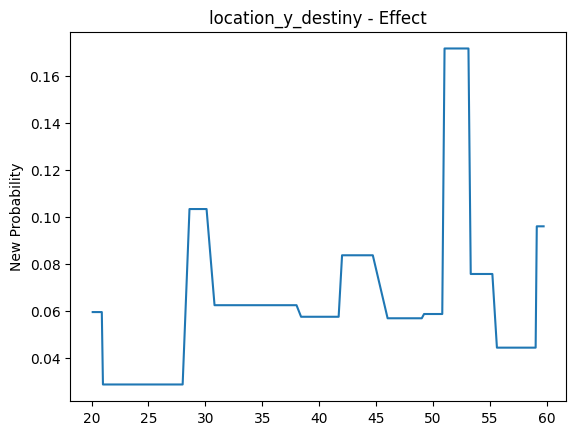

In [80]:
plt.plot(pp_df[feature_to_analyze], pp_df['pred'])
plt.xlabel('')
plt.ylabel('New Probability')
plt.title(feature_to_analyze +' - Effect')
plt.show()

### Top 5 - Feature Effect

In [81]:
pp_df = data_model_feat.copy()
for column in data_model_feat.columns:
    if data_model_feat[column].dtype == 'float64':
        avg = data_model_feat[column].mean()
        pp_df[column] = avg
    else:
        col1 = data_model_feat[column].astype(str)
        mode = col1.mode().values[0]
        pp_df[column] = mode

for i in colcat:
    pp_df[i] = pp_df[i].astype('category')

feature_to_analyze = feature_imp_df.reset_index().feature[4]
pp_df[feature_to_analyze] = data_model_feat[feature_to_analyze].tolist()

prediction = gbm_best.predict(pp_df)
pp_df['pred'] = prediction
pp_df = pp_df.sort_values([feature_to_analyze])
#pp_df = pp_df[pp_df[feature_to_analyze]<50]

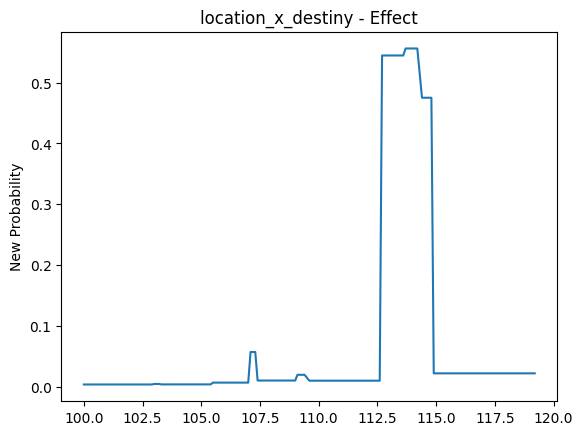

In [82]:
plt.plot(pp_df[feature_to_analyze], pp_df['pred'])
plt.xlabel('')
plt.ylabel('New Probability')
plt.title(feature_to_analyze +' - Effect')
plt.show()

# Simulation

Simulate passes from each center of each square from outside to inside the box, for all combinations for possitions and pass angles.

This to keep those passes with high probability of goal

For this, we will infer that the centroid of each square will have the same probability of each other point inside the square.

So, the centroid of each square will be calculated

## Define squares outside & inside the box

In [94]:
arists['big_area_destiny'] = np.where(arists.centroid_y is None, 0,
                                      np.where(((arists.centroid_x<=120) & (arists.centroid_x>=100) & (arists.centroid_y >= 20) & (arists.centroid_y<=60)),1,0))

Only passes since 1/4 of the court

In [95]:
arists_sim = arists[arists.x_il>=40]

In [96]:
arists_out = arists_sim[arists_sim['big_area_destiny']==0][['centroid_x','centroid_y']]
arists_in  = arists_sim[arists_sim['big_area_destiny']==1][['centroid_x','centroid_y']]

In [97]:
arists_out.columns = [['centroid_x_origin', 'centroid_y_origin']]
arists_in.columns  = [['centroid_x_destiny', 'centroid_y_destiny']]

## Get all the combinations for simulation

Grid of pass angle

In [99]:
grid_pass_height = ['High Pass', 'Low or Ground Pass']

In [132]:
combinations = list(product(arists_out[['centroid_x_origin', 'centroid_y_origin']].values,
                            arists_in[['centroid_x_destiny', 'centroid_y_destiny']].values,
                            grid_pass_height))

In [133]:
# Convert combinations to DataFrame
combinations = pd.DataFrame(combinations, columns=['centroid_origin', 'centroid_destiny', 'pass_height'])

In [134]:
len(combinations)

8960000

In [135]:
combinations['centroid_x_origin'] = combinations.centroid_origin.apply(coord_x)
combinations['centroid_y_origin'] = combinations.centroid_origin.apply(coord_y)

combinations['centroid_x_destiny'] = combinations.centroid_destiny.apply(coord_x)
combinations['centroid_y_destiny'] = combinations.centroid_destiny.apply(coord_y)

Calculate distance_length

In [136]:
combinations['distance_length'] = (((combinations['centroid_x_origin']-combinations['centroid_x_destiny'])**2)+(combinations['centroid_y_origin']-combinations['centroid_y_destiny'])**2)**(0.5)

In [137]:
combinations['pass_height'] = combinations['pass_height'].astype('category')

In [138]:
combinations.columns = ['centroid_origin', 'centroid_destiny', 'pass_height',
                         'location_x', 'location_y',
                         'location_x_destiny', 'location_y_destiny',
                         'pass_length']

In [140]:
combinations.head()

centroid_origin centroid_destiny         pass_height  location_x  \
0     [40.5, 0.5]    [100.5, 20.5]           High Pass        40.5   
1     [40.5, 0.5]    [100.5, 20.5]  Low or Ground Pass        40.5   
2     [40.5, 0.5]    [100.5, 21.5]           High Pass        40.5   
3     [40.5, 0.5]    [100.5, 21.5]  Low or Ground Pass        40.5   
4     [40.5, 0.5]    [100.5, 22.5]           High Pass        40.5   

   location_y  location_x_destiny  location_y_destiny  pass_length  
0         0.5               100.5                20.5    63.245553  
1         0.5               100.5                20.5    63.245553  
2         0.5               100.5                21.5    63.568860  
3         0.5               100.5                21.5    63.568860  
4         0.5               100.5                22.5    63.906181

## Get score of goal

Make a predict with the model fitted

In [141]:
combinations['score'] = gbm_best.predict(combinations[features])

## Top passes

Get the passes with higher probability of goal, for left, right and center of the box

In [157]:
def get_channel(row):
  if row['location_y_destiny'] <= 20+11:
    return 'left'
  elif row['location_y_destiny'] >= 60-11:
    return 'right'
  else:
    return 'center'

In [158]:
combinations['channel'] = combinations.apply(get_channel, axis = 1)

Get and viz the passes with higher probability of goal

In [159]:
top_passes_left   = combinations[combinations.channel == 'left'].sort_values('score', ascending = False).head(20)
top_passes_right  = combinations[combinations.channel == 'right'].sort_values('score', ascending = False).head(20)
top_passes_center = combinations[combinations.channel == 'center'].sort_values('score', ascending = False).head(20)

In [170]:
top_passes_left_high   = combinations[(combinations.channel == 'left') & (combinations.pass_height == 'High Pass')].sort_values('score', ascending = False).head(20)
top_passes_right_high  = combinations[(combinations.channel == 'right') & (combinations.pass_height == 'High Pass')].sort_values('score', ascending = False).head(20)
top_passes_center_high = combinations[(combinations.channel == 'center') & (combinations.pass_height == 'High Pass')].sort_values('score', ascending = False).head(20)

In [173]:
top_passes_left_low   = combinations[(combinations.channel == 'left')   & (combinations.pass_height == 'Low or Ground Pass')].sort_values('score', ascending = False).head(20)
top_passes_right_low  = combinations[(combinations.channel == 'right')  & (combinations.pass_height == 'Low or Ground Pass')].sort_values('score', ascending = False).head(20)
top_passes_center_low = combinations[(combinations.channel == 'center') & (combinations.pass_height == 'Low or Ground Pass')].sort_values('score', ascending = False).head(20)

## Viz of passes

Function to viz court in python

In [179]:
def plot_soccer_court():
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the figure size and axis limits
    fig.set_size_inches(7, 5)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)

    # Plot the outer boundary of the soccer court
    ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color='black')
    
    # Center line
    ax.plot([60, 60], [0, 80], color='black')
    
    # Left line
    ax.plot([100, 120], [20+11, 20+11], color='black')
    
    # Right Line
    ax.plot([100, 120], [60-11, 60-11], color='black')
    
    # Middle circle
    ax.add_patch(plt.Circle((60, 40), 9, color='black', fill=False))
    
    # Penalty areas
    ax.plot([0, 20], [20, 20], color='black')
    ax.plot([0, 20], [60, 60], color='black')
    ax.plot([20, 20], [20, 60], color='black')
    
    ax.plot([100, 120], [20, 20], color='black')
    ax.plot([100, 120], [60, 60], color='black')
    ax.plot([100, 100], [20, 60], color='black')
     
    
    # Set the aspect ratio to equal
    ax.set_aspect('equal')

    # Remove the axis labels and ticks
    ax.axis('off')

### All Passes

Text(0.5, 1.0, 'Best Passes to Center')

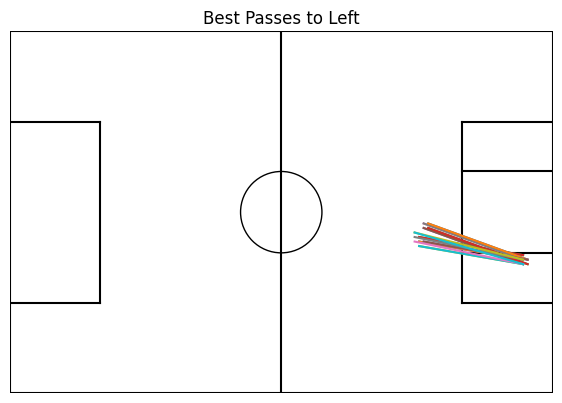

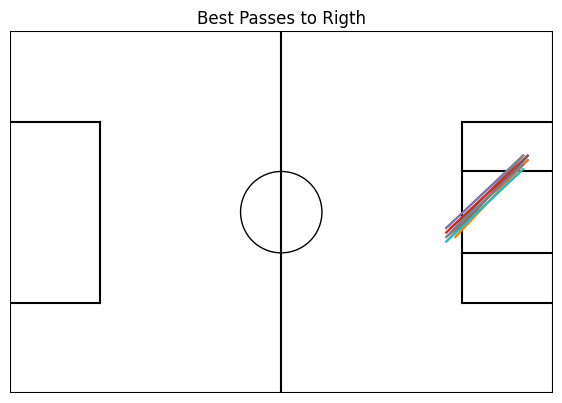

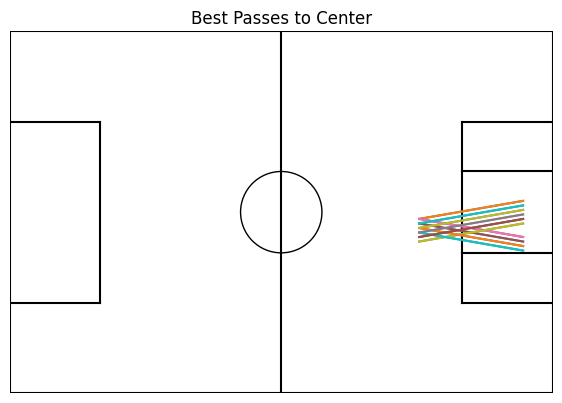

In [181]:
plot_soccer_court()
plt.plot([top_passes_left.location_x, top_passes_left.location_x_destiny],
         [top_passes_left.location_y, top_passes_left.location_y_destiny])
plt.title('Best Passes to Left')

plot_soccer_court()
plt.plot([top_passes_right.location_x, top_passes_right.location_x_destiny],
         [top_passes_right.location_y, top_passes_right.location_y_destiny])
plt.title('Best Passes to Rigth')

plot_soccer_court()
plt.plot([top_passes_center.location_x, top_passes_center.location_x_destiny],
         [top_passes_center.location_y, top_passes_center.location_y_destiny])
plt.title('Best Passes to Center')

### High Passes

Text(0.5, 1.0, 'Best Passes to Center - High')

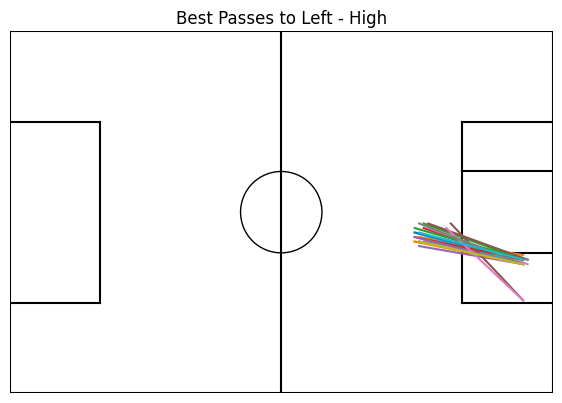

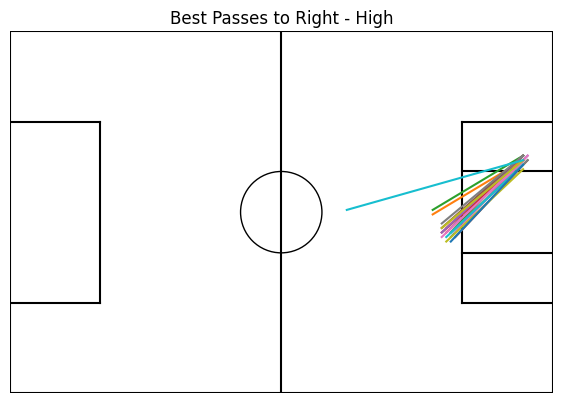

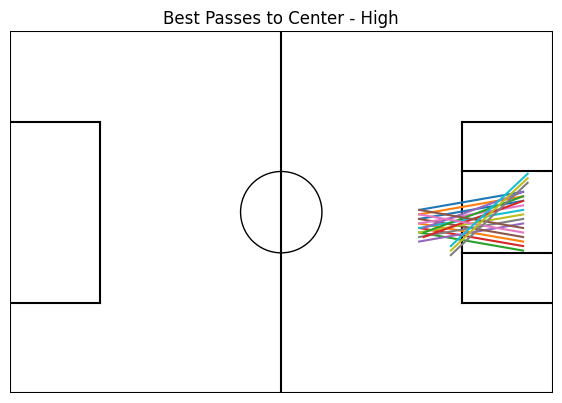

In [182]:
plot_soccer_court()
plt.plot([top_passes_left_high.location_x, top_passes_left_high.location_x_destiny],
         [top_passes_left_high.location_y, top_passes_left_high.location_y_destiny])
plt.title('Best Passes to Left - High')

plot_soccer_court()
plt.plot([top_passes_right_high.location_x, top_passes_right_high.location_x_destiny],
         [top_passes_right_high.location_y, top_passes_right_high.location_y_destiny])
plt.title('Best Passes to Right - High')

plot_soccer_court()
plt.plot([top_passes_center_high.location_x, top_passes_center_high.location_x_destiny],
         [top_passes_center_high.location_y, top_passes_center_high.location_y_destiny])
plt.title('Best Passes to Center - High')

### Low Passes

Text(0.5, 1.0, 'Best Passes to Center - Low or Ground')

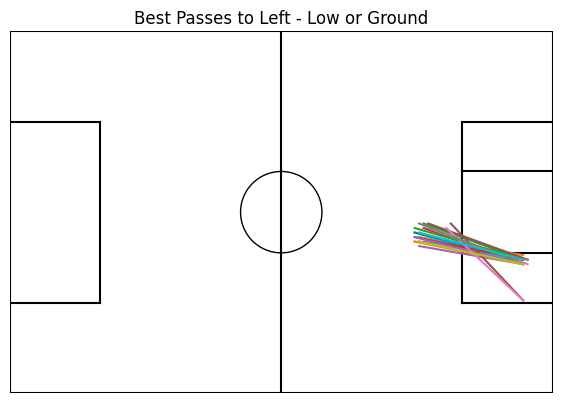

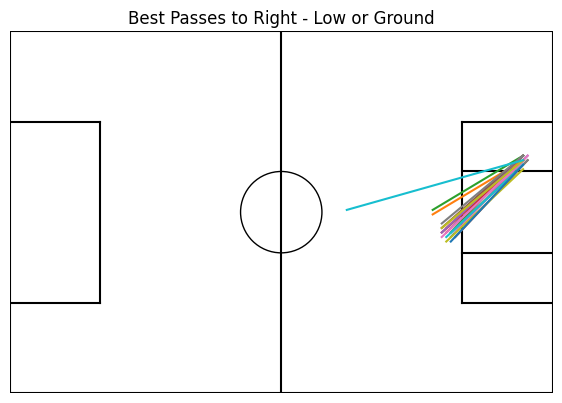

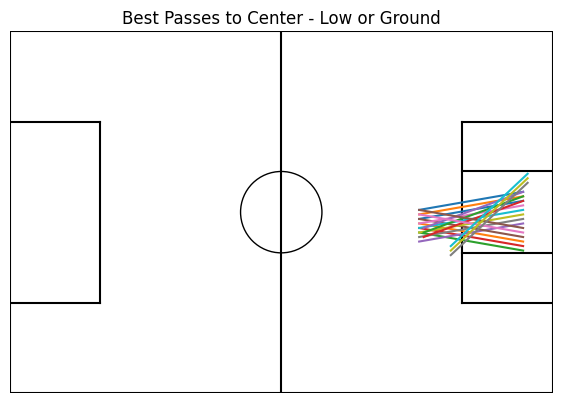

In [183]:
plot_soccer_court()
plt.plot([top_passes_left_low.location_x, top_passes_left_low.location_x_destiny],
         [top_passes_left_low.location_y, top_passes_left_low.location_y_destiny])
plt.title('Best Passes to Left - Low or Ground')

plot_soccer_court()
plt.plot([top_passes_right_low.location_x, top_passes_right_low.location_x_destiny],
         [top_passes_right_low.location_y, top_passes_right_low.location_y_destiny])
plt.title('Best Passes to Right - Low or Ground')

plot_soccer_court()
plt.plot([top_passes_center_low.location_x, top_passes_center_low.location_x_destiny],
         [top_passes_center_low.location_y, top_passes_center_low.location_y_destiny])
plt.title('Best Passes to Center - Low or Ground')